# K-meansでクラスタ数を決める

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
%matplotlib inline

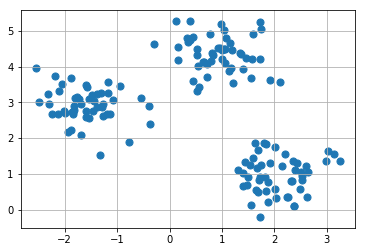

In [5]:
from sklearn.datasets import make_blobs  # ダミーデータの生成用

# Xには1つのプロットの(x,y)が、yにはそのプロットの所属するクラスター番号が入る
X, y = make_blobs(
    n_samples=150,  # サンプル点の総数
    n_features=2,  # 特徴量（次元数）の指定  default:2 
    centers=3,  # クラスタの個数
    cluster_std=0.5,  # クラスタ内の標準偏差 
    shuffle=True,  # サンプルをシャッフル
    random_state=0)  # 乱数生成器の状態を指定

plt.scatter(X[:, 0], X[:, 1], s=50)
plt.grid()
# plt.show()

In [6]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3,  # クラスターの個数
    init='random',  # セントロイドの初期値をランダムに設定  default: 'k-means++'
    n_init=
    10,  # 異なるセントロイドの初期値を用いたk-meansの実行回数 default: '10' 実行したうちもっとSSE値が小さいモデルを最終モデルとして選択
    max_iter=300,  # k-meansアルゴリズムの内部の最大イテレーション回数  default: '300'
    tol=1e-04,  # 収束と判定するための相対的な許容誤差 default: '1e-04'
    random_state=0)  # セントロイドの初期化に用いる乱数発生器の状態

y_km = km.fit_predict(X)

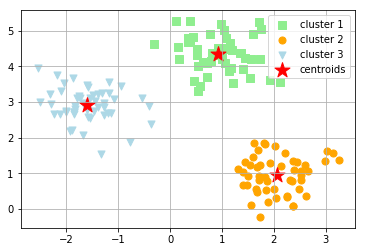

In [7]:
plt.scatter(
    X[y_km == 0, 0],  # y_km（クラスター番号）が0の時にXの0列目を抽出
    X[y_km == 0, 1],  # y_km（クラスター番号）が0の時にXの1列目を抽出
    s=50,
    c='lightgreen',
    marker='s',
    label='cluster 1')

plt.scatter(
    X[y_km == 1, 0],
    X[y_km == 1, 1],
    s=50,
    c='orange',
    marker='o',
    label='cluster 2')

plt.scatter(
    X[y_km == 2, 0],
    X[y_km == 2, 1],
    s=50,
    c='lightblue',
    marker='v',
    label='cluster 3')

plt.scatter(
    km.cluster_centers_[:, 0],  # km.cluster_centers_には各クラスターのセントロイドの座標が入っている
    km.cluster_centers_[:, 1],
    s=250,
    marker='*',
    c='red',
    label='centroids')

plt.legend()
plt.grid()
plt.show()

## クラスタ内誤差平方和（SSE）

In [8]:
print ('Distortion: %.2f'% km.inertia_)

Distortion: 72.48


## エルボー法とは

- クラスタごとのSSE値をプロットした図
- SSE値が"ヒジ"のようにガクンと曲がった点（SSE値の低下が収束すると思われる場所）が最適なクラスター数とみなす

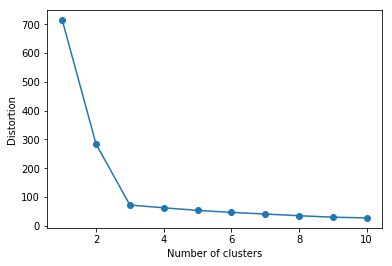

In [9]:
# SSEを格納するリスト
distortions = []

# 1~10クラスタまで一気に計算
for i in range(1, 11):
    
    # n_clusters= i を 動的に変えてSSEを算出
    km = KMeans(
        n_clusters=i,
        init='k-means++', 
        n_init=10,
        max_iter=300,
        random_state=0)

    # クラスタリングの計算を実行
    km.fit(X)  
    
    # SSEを格納    
    distortions.append(km.inertia_)  

    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

3くらいからSSEに変化がない為、クラスタ数は3と判断

## シルエット分析 Silhouette analysis とは

- クラスタ内のサンプルがどの程度密にグループされているか（凝集度）の目安となるグラフを可視化  
（=パッと見でクラスターが上手くできているかなんとなくわかる）

- １つのクラスターが隣接するクラスターとどれくらい離れているかを可視化する
- 適切なクラスター数がどれくらいかを調べるためにも使える
- シルエット分析はK-measn法以外のクラスタリングアルゴリズムにも適応できる

### シルエットを描画

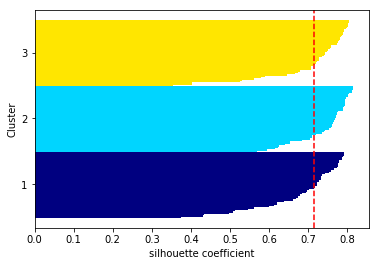

In [10]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

# y_kmの要素の中で重複を無くす
cluster_labels = np.unique(y_km)

# 配列の長さを返す。つまりここでは n_clustersで指定した3となる
n_clusters = cluster_labels.shape[0]

# シルエット係数を計算
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')

# サンプルデータ, クラスター番号、ユークリッド距離でシルエット係数計算
y_ax_lower, y_ax_upper = 0, 0

yticks = []

for i, c in enumerate(cluster_labels):

    c_silhouette_vals = silhouette_vals[y_km == c]

    # cluster_labelsには 0,1,2が入っている（enumerateなのでiにも0,1,2が入ってる（たまたま））
    c_silhouette_vals.sort()

    # サンプルの個数をクラスターごとに足し上げてy軸の最大値を決定
    y_ax_upper += len(c_silhouette_vals)

    # 色の値を作る
    color = cm.jet(float(i) / n_clusters)
    plt.barh(
        range(y_ax_lower, y_ax_upper),  # 水平の棒グラフを描画（底辺の範囲を指定）
        c_silhouette_vals,  # 棒の幅（1サンプルを表す）
        height=1.0,  # 棒の高さ
        edgecolor='none',  # 棒の端の色
        color=color)  # 棒の色

    # クラスタラベルの表示位置を追加
    yticks.append((y_ax_lower + y_ax_upper) / 2)

    # 底辺の値に棒の幅を追加
    y_ax_lower += len(c_silhouette_vals)

# シルエット係数の平均値
silhouette_avg = np.mean(silhouette_vals)

# 係数の平均値に破線を引く
plt.axvline(silhouette_avg, color="red", linestyle="--")

# クラスタレベルを表示
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')
plt.show()

### シルエット図の見方

- クラスターの「シルエット係数 silhouette coefficient 」が 1に近いほど、そのクラスターは他のクラスターから遠く離れていることを表す。  
（係数は -1 ~ 1の間をとる）

- 0に近いほど隣接するクラスターと接近している or 隣接するクラスターと重なっていることを表す。  
（上手くクラスターの分離ができていない状態）

- 係数がマイナス値だとクラスター化されたサンプルは間違ったクラスターに所属している可能性がある
- シルエットの"厚さ thickness"はクラスターのサイズ（所属するサンプル数）を表す
- 適切にクラスター分離できていれば各クラスターのシルエットの"厚さ"は均等に近くなるらしい


# X-means

クラスタ数を自動推定するX-means法について

- Pelleg and Moore (2000)が提案したK-meansの拡張アルゴリズム。
- クラスター数Kを自動決定する
- k-meansをデータ数が多くても高速に動くようなアルゴリズムに工夫する

[X-means: Extending K-means with Efficient Estimation of the Number of Clusters | Carnegie Mellon Univ. (2000)](http://www.cs.cmu.edu/~dpelleg/download/xmeans.pdf)



## x-means概要

- k-meansの逐次繰り返しとBICによる分割停止基準を用いて最適なクラスター数を決定する
- BICの計算方法にバリエーションがある

- 基本的なアイデアは「データは、重心の近くにガウス分布している」ということを仮定して、確率分布の概念を導入し、そこから尤度という概念が生まれるので、BICが計算できるという流れ

- x-meansではk-meansを再帰的に呼び出し利用をしている
- k-meansの欠点（初期値依存性）をひきづっている
- クラスターは計算毎に少しづつ変わる
- しかし、クラスターサイズは安定してので最適なクラスター数の目安にはなる
- 先験情報が全く無い時に、発見的な方法に拠らずk-meansのおおよそ2倍強の計算量で最適なクラスター数を求めることができる

### 計算の流れ
1. 少ないクラスター数でk-meansして、
1. 出来たクラスターを2-meansして、クラスターを分割し、
1. もしBICが大きくなったら、採用し、2に戻る


In [11]:
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from IPython.display import display, HTML
%matplotlib inline

In [21]:
"""
以下の論文で提案された改良x-means法の実装
クラスター数を自動決定するk-meansアルゴリズムの拡張について
http://www.rd.dnc.ac.jp/~tunenori/doc/xmeans_euc.pdf
"""

import numpy as np
from scipy import stats
from sklearn.cluster import KMeans


class XMeans:
    """
    x-means法を行うクラス
    """

    def __init__(self, k_init=2, **k_means_args):
        """
        k_init : The initial number of clusters applied to KMeans()
        """
        self.k_init = k_init
        self.k_means_args = k_means_args

    def fit(self, X):
        """
        x-means法を使ってデータXをクラスタリングする
        X : array-like or sparse matrix, shape=(n_samples, n_features)
        """
        self.__clusters = []

        clusters = self.Cluster.build(
            X,
            KMeans(self.k_init, **self.k_means_args).fit(X))
        self.__recursively_split(clusters)

        self.labels_ = np.empty(X.shape[0], dtype=np.intp)
        for i, c in enumerate(self.__clusters):
            self.labels_[c.index] = i

        self.cluster_centers_ = np.array([c.center for c in self.__clusters])
        self.cluster_log_likelihoods_ = np.array(
            [c.log_likelihood() for c in self.__clusters])
        self.cluster_sizes_ = np.array([c.size for c in self.__clusters])

        return self

    def __recursively_split(self, clusters):
        """
        引数のclustersを再帰的に分割する
        clusters : list-like object, which contains instances of 'XMeans.Cluster'
        """
        for cluster in clusters:
            if cluster.size <= 3:
                self.__clusters.append(cluster)
                continue

            k_means = KMeans(2, **self.k_means_args).fit(cluster.data)
            c1, c2 = self.Cluster.build(cluster.data, k_means, cluster.index)

            beta = np.linalg.norm(c1.center - c2.center) / np.sqrt(
                np.linalg.det(c1.cov) + np.linalg.det(c2.cov))
            alpha = 0.5 / stats.norm.cdf(beta)
            bic = -2 * (cluster.size * np.log(alpha) + c1.log_likelihood(
            ) + c2.log_likelihood()) + 2 * cluster.df * np.log(cluster.size)

            if bic < cluster.bic():
                self.__recursively_split([c1, c2])
            else:
                self.__clusters.append(cluster)

    class Cluster:
        """
        k-means法によって生成されたクラスタに関する情報を持ち、尤度やBICの計算を行うクラス
        """

        @classmethod
        def build(cls, X, k_means, index=None):
            if index is None:
                index = np.array(range(0, X.shape[0]))
            labels = range(0, k_means.get_params()["n_clusters"])

            return tuple(cls(X, index, k_means, label) for label in labels)

        # index: Xの各行におけるサンプルが元データの何行目のものかを示すベクトル
        def __init__(self, X, index, k_means, label):
            self.data = X[k_means.labels_ == label]
            self.index = index[k_means.labels_ == label]
            self.size = self.data.shape[0]
            self.df = self.data.shape[1] * (self.data.shape[1] + 3) / 2
            self.center = k_means.cluster_centers_[label]
            self.cov = np.cov(self.data.T)

        def log_likelihood(self):
            return sum(
                stats.multivariate_normal.logpdf(x, self.center, self.cov)
                for x in self.data)

        def bic(self):
            return -2 * self.log_likelihood() + self.df * np.log(self.size)

No handles with labels found to put in legend.


### x_means.cluster_sizes_
### x_means.labels_ : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2]
### x_means.cluster_centers_ : [[1.99410056 0.96724537]
 [0.98731702 1.02074076]
 [2.01236093 1.99114544]
 [0.99793477 2.02135099]]
### x_means.cluster_log_likelihoods_ : [46.32638297 33.84764985 37.63213884 46.94980231]
### x_means.cluster_num : (4,)


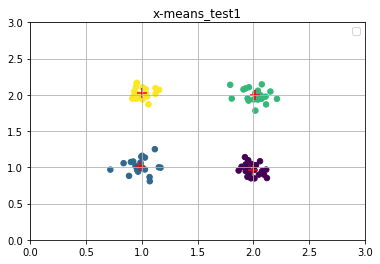

In [28]:
# データの準備

#ランダムな80個の数を生成
x = np.array([np.random.normal(loc, 0.1, 20)
              for loc in np.repeat([1, 2], 2)]).flatten()

#ランダムな80個の数を生成
y = np.array(
    [np.random.normal(loc, 0.1, 20) for loc in np.tile([1, 2], 2)]).flatten()

# クラスタリングの実行
x_means = XMeans(random_state=1).fit(np.c_[x, y])

print("### x_means.cluster_sizes_".format(x_means.cluster_sizes_))
print("### x_means.labels_ : {}".format(x_means.labels_))
print("### x_means.cluster_centers_ : {}".format(x_means.cluster_centers_))
print("### x_means.cluster_log_likelihoods_ : {}".format(x_means.cluster_log_likelihoods_))
print("### x_means.cluster_num : {}".format(x_means.cluster_sizes_.shape))

# 結果をプロット
plt.rcParams["font.family"] = "Hiragino Kaku Gothic Pro"
plt.scatter(x, y, c=x_means.labels_, s=30)
plt.scatter(
    x_means.cluster_centers_[:, 0],
    x_means.cluster_centers_[:, 1],
    c="r",
    marker="+",
    s=100)
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.title("x-means_test1")
plt.legend()
plt.grid()
plt.show()